2024-06-19 20:49:13.383491: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 20:49:14.943015: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


../data/SWED/test/images/S2A_MSIL2A_20200107T175721_N0213_R141_T12QVM_20200107T214721_image_0_0.tif
98


Loading data:   0%|          | 0/98 [00:00<?, ?it/s]/usr/lib/python3/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
Loading data: 100%|██████████| 98/98 [00:00<00:00, 128.56it/s]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

  0%|          | 0/50 [00:00<?, ?epoch/s]

Epoch 1/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:24 42s/step - accuracy: 0.0256 - dice_coef: 0.0048 - iou_metric: 0.0024 - loss: 0.6932

2/3 ━━━━━━━━━━━━━━━━━━━━ 36s 37s/step - accuracy: 0.1193 - dice_coef: 0.0048 - iou_metric: 0.0024 - loss: 0.6920 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.1688 - dice_coef: 0.0046 - iou_metric: 0.0023 - loss: 0.6896 
Epoch 1: val_loss improved from inf to 0.03026, saving model to unet_model.weights.h5


2024-06-19 20:51:00.967797: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2264924160 exceeds 10% of free system memory.
  2%|▏         | 1/50 [01:44<1:25:05, 104.20s/epoch, accuracy=0.268, dice_coef=0.00441, iou_metric=0.00221, loss=0.685, val_accuracy=0.471, val_dice_coef=0.00341, val_iou_metric=0.00171, val_loss=0.0303]

3/3 ━━━━━━━━━━━━━━━━━━━━ 104s 31s/step - accuracy: 0.1935 - dice_coef: 0.0046 - iou_metric: 0.0023 - loss: 0.6884 - val_accuracy: 0.4710 - val_dice_coef: 0.0034 - val_iou_metric: 0.0017 - val_loss: 0.0303


Epoch 2/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:11 36s/step - accuracy: 0.4395 - dice_coef: 0.0035 - iou_metric: 0.0017 - loss: 0.0314

2/3 ━━━━━━━━━━━━━━━━━━━━ 35s 36s/step - accuracy: 0.4358 - dice_coef: 0.0026 - iou_metric: 0.0013 - loss: 0.0718 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.4293 - dice_coef: 0.0027 - iou_metric: 0.0014 - loss: 0.0887 
Epoch 2: val_loss improved from 0.03026 to 0.02748, saving model to unet_model.weights.h5


2024-06-19 20:52:37.374865: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2264924160 exceeds 10% of free system memory.
  4%|▍         | 2/50 [03:20<1:19:42, 99.64s/epoch, accuracy=0.416, dice_coef=0.00289, iou_metric=0.00145, loss=0.123, val_accuracy=0.471, val_dice_coef=0.0035, val_iou_metric=0.00176, val_loss=0.0275]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 96s 30s/step - accuracy: 0.4261 - dice_coef: 0.0028 - iou_metric: 0.0014 - loss: 0.0972 - val_accuracy: 0.4710 - val_dice_coef: 0.0035 - val_iou_metric: 0.0018 - val_loss: 0.0275


Epoch 3/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:12 36s/step - accuracy: 0.3931 - dice_coef: 0.0040 - iou_metric: 0.0020 - loss: 0.0294

2/3 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - accuracy: 0.3891 - dice_coef: 0.0035 - iou_metric: 0.0018 - loss: 0.0331 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.3982 - dice_coef: 0.0031 - iou_metric: 0.0016 - loss: 0.0345 
Epoch 3: val_loss did not improve from 0.02748


2024-06-19 20:54:08.072848: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2264924160 exceeds 10% of free system memory.
  6%|▌         | 3/50 [04:51<1:14:48, 95.50s/epoch, accuracy=0.416, dice_coef=0.00238, iou_metric=0.00119, loss=0.0373, val_accuracy=0.471, val_dice_coef=0.00126, val_iou_metric=0.000629, val_loss=0.0463]

3/3 ━━━━━━━━━━━━━━━━━━━━ 91s 27s/step - accuracy: 0.4027 - dice_coef: 0.0029 - iou_metric: 0.0015 - loss: 0.0352 - val_accuracy: 0.4710 - val_dice_coef: 0.0013 - val_iou_metric: 6.2949e-04 - val_loss: 0.0463


Epoch 4/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:05 33s/step - accuracy: 0.4286 - dice_coef: 0.0012 - iou_metric: 5.9893e-04 - loss: 0.0498

2/3 ━━━━━━━━━━━━━━━━━━━━ 32s 33s/step - accuracy: 0.4247 - dice_coef: 0.0014 - iou_metric: 6.9723e-04 - loss: 0.0467 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.4219 - dice_coef: 0.0016 - iou_metric: 7.9926e-04 - loss: 0.0447 
Epoch 4: val_loss did not improve from 0.02748


2024-06-19 20:55:36.702601: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2264924160 exceeds 10% of free system memory.
  8%|▊         | 4/50 [06:19<1:11:07, 92.78s/epoch, accuracy=0.416, dice_coef=0.002, iou_metric=0.001, loss=0.0406, val_accuracy=0.471, val_dice_coef=0.00362, val_iou_metric=0.00181, val_loss=0.0284]     

3/3 ━━━━━━━━━━━━━━━━━━━━ 89s 28s/step - accuracy: 0.4205 - dice_coef: 0.0017 - iou_metric: 8.5027e-04 - loss: 0.0437 - val_accuracy: 0.4710 - val_dice_coef: 0.0036 - val_iou_metric: 0.0018 - val_loss: 0.0284


Epoch 5/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:05 33s/step - accuracy: 0.4284 - dice_coef: 0.0039 - iou_metric: 0.0019 - loss: 0.0292

2/3 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - accuracy: 0.4235 - dice_coef: 0.0039 - iou_metric: 0.0020 - loss: 0.0287 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.4211 - dice_coef: 0.0038 - iou_metric: 0.0019 - loss: 0.0283 
Epoch 5: val_loss improved from 0.02748 to 0.02437, saving model to unet_model.weights.h5


2024-06-19 20:57:08.268727: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2264924160 exceeds 10% of free system memory.
 10%|█         | 5/50 [07:51<1:09:19, 92.42s/epoch, accuracy=0.416, dice_coef=0.00353, iou_metric=0.00177, loss=0.0276, val_accuracy=0.471, val_dice_coef=0.00225, val_iou_metric=0.00113, val_loss=0.0244]

3/3 ━━━━━━━━━━━━━━━━━━━━ 92s 30s/step - accuracy: 0.4199 - dice_coef: 0.0037 - iou_metric: 0.0019 - loss: 0.0281 - val_accuracy: 0.4710 - val_dice_coef: 0.0023 - val_iou_metric: 0.0011 - val_loss: 0.0244


Epoch 6/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:10 35s/step - accuracy: 0.4080 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0270

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4201 - dice_coef: 0.0023 - iou_metric: 0.0012 - loss: 0.0259 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4189 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0255 
Epoch 6: val_loss improved from 0.02437 to 0.02115, saving model to unet_model.weights.h5


 12%|█▏        | 6/50 [09:21<1:07:01, 91.40s/epoch, accuracy=0.416, dice_coef=0.00263, iou_metric=0.00132, loss=0.0246, val_accuracy=0.471, val_dice_coef=0.00324, val_iou_metric=0.00162, val_loss=0.0211]

3/3 ━━━━━━━━━━━━━━━━━━━━ 89s 27s/step - accuracy: 0.4182 - dice_coef: 0.0025 - iou_metric: 0.0012 - loss: 0.0253 - val_accuracy: 0.4710 - val_dice_coef: 0.0032 - val_iou_metric: 0.0016 - val_loss: 0.0211


Epoch 7/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:04 32s/step - accuracy: 0.4376 - dice_coef: 0.0034 - iou_metric: 0.0017 - loss: 0.0219

2/3 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - accuracy: 0.4372 - dice_coef: 0.0034 - iou_metric: 0.0017 - loss: 0.0216 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4302 - dice_coef: 0.0033 - iou_metric: 0.0017 - loss: 0.0217 
Epoch 7: val_loss improved from 0.02115 to 0.01846, saving model to unet_model.weights.h5


 14%|█▍        | 7/50 [10:47<1:04:24, 89.86s/epoch, accuracy=0.416, dice_coef=0.00321, iou_metric=0.00161, loss=0.0217, val_accuracy=0.471, val_dice_coef=0.00219, val_iou_metric=0.00109, val_loss=0.0185]

3/3 ━━━━━━━━━━━━━━━━━━━━ 87s 27s/step - accuracy: 0.4267 - dice_coef: 0.0033 - iou_metric: 0.0017 - loss: 0.0217 - val_accuracy: 0.4710 - val_dice_coef: 0.0022 - val_iou_metric: 0.0011 - val_loss: 0.0185


Epoch 8/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:04 32s/step - accuracy: 0.4354 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0195

2/3 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - accuracy: 0.4272 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0194 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.4236 - dice_coef: 0.0025 - iou_metric: 0.0013 - loss: 0.0193 
Epoch 8: val_loss improved from 0.01846 to 0.01634, saving model to unet_model.weights.h5


 16%|█▌        | 8/50 [12:14<1:02:17, 89.00s/epoch, accuracy=0.416, dice_coef=0.00269, iou_metric=0.00135, loss=0.0191, val_accuracy=0.471, val_dice_coef=0.0024, val_iou_metric=0.0012, val_loss=0.0163]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 87s 28s/step - accuracy: 0.4218 - dice_coef: 0.0026 - iou_metric: 0.0013 - loss: 0.0192 - val_accuracy: 0.4710 - val_dice_coef: 0.0024 - val_iou_metric: 0.0012 - val_loss: 0.0163


Epoch 9/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:04 32s/step - accuracy: 0.4234 - dice_coef: 0.0025 - iou_metric: 0.0013 - loss: 0.0175

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4283 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0174 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4243 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0174 
Epoch 9: val_loss improved from 0.01634 to 0.01602, saving model to unet_model.weights.h5


 18%|█▊        | 9/50 [13:41<1:00:13, 88.13s/epoch, accuracy=0.416, dice_coef=0.00238, iou_metric=0.00119, loss=0.0175, val_accuracy=0.471, val_dice_coef=0.00278, val_iou_metric=0.00139, val_loss=0.016]

3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 27s/step - accuracy: 0.4223 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0174 - val_accuracy: 0.4710 - val_dice_coef: 0.0028 - val_iou_metric: 0.0014 - val_loss: 0.0160


Epoch 10/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4639 - dice_coef: 0.0028 - iou_metric: 0.0014 - loss: 0.0162

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4389 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0169 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4314 - dice_coef: 0.0023 - iou_metric: 0.0011 - loss: 0.0170 
Epoch 10: val_loss improved from 0.01602 to 0.01589, saving model to unet_model.weights.h5


 20%|██        | 10/50 [15:07<58:18, 87.46s/epoch, accuracy=0.416, dice_coef=0.00202, iou_metric=0.00101, loss=0.0173, val_accuracy=0.471, val_dice_coef=0.00278, val_iou_metric=0.00139, val_loss=0.0159]

3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 27s/step - accuracy: 0.4276 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0171 - val_accuracy: 0.4710 - val_dice_coef: 0.0028 - val_iou_metric: 0.0014 - val_loss: 0.0159


Epoch 11/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4031 - dice_coef: 0.0030 - iou_metric: 0.0015 - loss: 0.0174

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4068 - dice_coef: 0.0027 - iou_metric: 0.0013 - loss: 0.0171 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4100 - dice_coef: 0.0025 - iou_metric: 0.0013 - loss: 0.0170 
Epoch 11: val_loss improved from 0.01589 to 0.01510, saving model to unet_model.weights.h5


 22%|██▏       | 11/50 [16:33<56:34, 87.03s/epoch, accuracy=0.416, dice_coef=0.00213, iou_metric=0.00107, loss=0.0168, val_accuracy=0.471, val_dice_coef=0.0023, val_iou_metric=0.00115, val_loss=0.0151] 

3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 27s/step - accuracy: 0.4116 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0169 - val_accuracy: 0.4710 - val_dice_coef: 0.0023 - val_iou_metric: 0.0012 - val_loss: 0.0151


Epoch 12/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.3879 - dice_coef: 0.0025 - iou_metric: 0.0012 - loss: 0.0171

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4044 - dice_coef: 0.0025 - iou_metric: 0.0013 - loss: 0.0167 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4084 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0167 
Epoch 12: val_loss improved from 0.01510 to 0.01504, saving model to unet_model.weights.h5


 24%|██▍       | 12/50 [17:59<54:57, 86.77s/epoch, accuracy=0.416, dice_coef=0.00223, iou_metric=0.00112, loss=0.0165, val_accuracy=0.471, val_dice_coef=0.00173, val_iou_metric=0.000868, val_loss=0.015]

3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 27s/step - accuracy: 0.4104 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0166 - val_accuracy: 0.4710 - val_dice_coef: 0.0017 - val_iou_metric: 8.6758e-04 - val_loss: 0.0150


Epoch 13/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4436 - dice_coef: 0.0017 - iou_metric: 8.7105e-04 - loss: 0.0158

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4204 - dice_coef: 0.0020 - iou_metric: 9.8518e-04 - loss: 0.0163 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4191 - dice_coef: 0.0021 - iou_metric: 0.0010 - loss: 0.0163     
Epoch 13: val_loss did not improve from 0.01504


 26%|██▌       | 13/50 [19:24<53:08, 86.18s/epoch, accuracy=0.416, dice_coef=0.00228, iou_metric=0.00114, loss=0.0164, val_accuracy=0.471, val_dice_coef=0.00153, val_iou_metric=0.000764, val_loss=0.0152]

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 26s/step - accuracy: 0.4184 - dice_coef: 0.0021 - iou_metric: 0.0011 - loss: 0.0164 - val_accuracy: 0.4710 - val_dice_coef: 0.0015 - val_iou_metric: 7.6432e-04 - val_loss: 0.0152


Epoch 14/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4088 - dice_coef: 0.0016 - iou_metric: 7.8404e-04 - loss: 0.0168

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4112 - dice_coef: 0.0016 - iou_metric: 7.7836e-04 - loss: 0.0168 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4129 - dice_coef: 0.0017 - iou_metric: 8.2755e-04 - loss: 0.0167 
Epoch 14: val_loss did not improve from 0.01504


 28%|██▊       | 14/50 [20:48<51:28, 85.78s/epoch, accuracy=0.416, dice_coef=0.00185, iou_metric=0.000926, loss=0.0166, val_accuracy=0.471, val_dice_coef=0.00257, val_iou_metric=0.00129, val_loss=0.0154]

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 26s/step - accuracy: 0.4138 - dice_coef: 0.0017 - iou_metric: 8.5214e-04 - loss: 0.0167 - val_accuracy: 0.4710 - val_dice_coef: 0.0026 - val_iou_metric: 0.0013 - val_loss: 0.0154


Epoch 15/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.3750 - dice_coef: 0.0029 - iou_metric: 0.0014 - loss: 0.0175

2/3 ━━━━━━━━━━━━━━━━━━━━ 32s 33s/step - accuracy: 0.3889 - dice_coef: 0.0026 - iou_metric: 0.0013 - loss: 0.0171 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.3980 - dice_coef: 0.0025 - iou_metric: 0.0012 - loss: 0.0169 
Epoch 15: val_loss improved from 0.01504 to 0.01497, saving model to unet_model.weights.h5


 30%|███       | 15/50 [22:15<50:12, 86.08s/epoch, accuracy=0.416, dice_coef=0.00212, iou_metric=0.00106, loss=0.0164, val_accuracy=0.471, val_dice_coef=0.0018, val_iou_metric=0.0009, val_loss=0.015]    

3/3 ━━━━━━━━━━━━━━━━━━━━ 87s 27s/step - accuracy: 0.4026 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0168 - val_accuracy: 0.4710 - val_dice_coef: 0.0018 - val_iou_metric: 9.0043e-04 - val_loss: 0.0150


Epoch 16/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4244 - dice_coef: 0.0018 - iou_metric: 9.2363e-04 - loss: 0.0162

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4138 - dice_coef: 0.0020 - iou_metric: 0.0010 - loss: 0.0164     

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4147 - dice_coef: 0.0021 - iou_metric: 0.0011 - loss: 0.0164 
Epoch 16: val_loss did not improve from 0.01497


 32%|███▏      | 16/50 [23:41<48:38, 85.84s/epoch, accuracy=0.416, dice_coef=0.00231, iou_metric=0.00116, loss=0.0164, val_accuracy=0.471, val_dice_coef=0.00165, val_iou_metric=0.000824, val_loss=0.015]

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.4151 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0164 - val_accuracy: 0.4710 - val_dice_coef: 0.0016 - val_iou_metric: 8.2351e-04 - val_loss: 0.0150


Epoch 17/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.3541 - dice_coef: 0.0018 - iou_metric: 9.0838e-04 - loss: 0.0181

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.3822 - dice_coef: 0.0018 - iou_metric: 8.9496e-04 - loss: 0.0173 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.3935 - dice_coef: 0.0018 - iou_metric: 9.1485e-04 - loss: 0.0170 
Epoch 17: val_loss did not improve from 0.01497


 34%|███▍      | 17/50 [25:06<47:08, 85.70s/epoch, accuracy=0.416, dice_coef=0.00191, iou_metric=0.000955, loss=0.0164, val_accuracy=0.471, val_dice_coef=0.00233, val_iou_metric=0.00116, val_loss=0.0151]

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.3992 - dice_coef: 0.0018 - iou_metric: 9.2480e-04 - loss: 0.0169 - val_accuracy: 0.4710 - val_dice_coef: 0.0023 - val_iou_metric: 0.0012 - val_loss: 0.0151


Epoch 18/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:04 32s/step - accuracy: 0.4238 - dice_coef: 0.0025 - iou_metric: 0.0012 - loss: 0.0161

2/3 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - accuracy: 0.4169 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0163 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4167 - dice_coef: 0.0023 - iou_metric: 0.0012 - loss: 0.0163 
Epoch 18: val_loss improved from 0.01497 to 0.01492, saving model to unet_model.weights.h5


 36%|███▌      | 18/50 [26:32<45:50, 85.95s/epoch, accuracy=0.416, dice_coef=0.00218, iou_metric=0.00109, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.00197, val_iou_metric=0.000986, val_loss=0.0149]

3/3 ━━━━━━━━━━━━━━━━━━━━ 87s 27s/step - accuracy: 0.4166 - dice_coef: 0.0023 - iou_metric: 0.0011 - loss: 0.0163 - val_accuracy: 0.4710 - val_dice_coef: 0.0020 - val_iou_metric: 9.8555e-04 - val_loss: 0.0149


Epoch 19/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:04 32s/step - accuracy: 0.4052 - dice_coef: 0.0021 - iou_metric: 0.0010 - loss: 0.0165

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4019 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0166 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4067 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0165 
Epoch 19: val_loss did not improve from 0.01492


 38%|███▊      | 19/50 [27:58<44:24, 85.94s/epoch, accuracy=0.416, dice_coef=0.00223, iou_metric=0.00112, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.00179, val_iou_metric=0.000894, val_loss=0.015] 

3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 27s/step - accuracy: 0.4091 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0164 - val_accuracy: 0.4710 - val_dice_coef: 0.0018 - val_iou_metric: 8.9355e-04 - val_loss: 0.0150


Epoch 20/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.3969 - dice_coef: 0.0019 - iou_metric: 9.4611e-04 - loss: 0.0168

2/3 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - accuracy: 0.4046 - dice_coef: 0.0019 - iou_metric: 9.4182e-04 - loss: 0.0166 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4085 - dice_coef: 0.0019 - iou_metric: 9.6405e-04 - loss: 0.0165 
Epoch 20: val_loss did not improve from 0.01492


 40%|████      | 20/50 [29:25<43:00, 86.03s/epoch, accuracy=0.416, dice_coef=0.00201, iou_metric=0.00101, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.0023, val_iou_metric=0.00115, val_loss=0.015]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 27s/step - accuracy: 0.4105 - dice_coef: 0.0019 - iou_metric: 9.7517e-04 - loss: 0.0165 - val_accuracy: 0.4710 - val_dice_coef: 0.0023 - val_iou_metric: 0.0012 - val_loss: 0.0150


Epoch 21/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:04 32s/step - accuracy: 0.3976 - dice_coef: 0.0025 - iou_metric: 0.0012 - loss: 0.0167

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4131 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0163 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4142 - dice_coef: 0.0023 - iou_metric: 0.0012 - loss: 0.0163 
Epoch 21: val_loss did not improve from 0.01492


 42%|████▏     | 21/50 [30:50<41:32, 85.96s/epoch, accuracy=0.416, dice_coef=0.00216, iou_metric=0.00108, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.00211, val_iou_metric=0.00106, val_loss=0.0149]

3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 27s/step - accuracy: 0.4147 - dice_coef: 0.0023 - iou_metric: 0.0011 - loss: 0.0163 - val_accuracy: 0.4710 - val_dice_coef: 0.0021 - val_iou_metric: 0.0011 - val_loss: 0.0149


Epoch 22/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4193 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0162

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4064 - dice_coef: 0.0023 - iou_metric: 0.0012 - loss: 0.0165 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4097 - dice_coef: 0.0023 - iou_metric: 0.0012 - loss: 0.0164 
Epoch 22: val_loss did not improve from 0.01492


 44%|████▍     | 22/50 [32:16<40:01, 85.77s/epoch, accuracy=0.416, dice_coef=0.00229, iou_metric=0.00115, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.00156, val_iou_metric=0.000782, val_loss=0.0151]

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.4114 - dice_coef: 0.0023 - iou_metric: 0.0012 - loss: 0.0164 - val_accuracy: 0.4710 - val_dice_coef: 0.0016 - val_iou_metric: 7.8166e-04 - val_loss: 0.0151


Epoch 23/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4329 - dice_coef: 0.0016 - iou_metric: 7.9292e-04 - loss: 0.0161

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4136 - dice_coef: 0.0017 - iou_metric: 8.2870e-04 - loss: 0.0165 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4145 - dice_coef: 0.0017 - iou_metric: 8.7359e-04 - loss: 0.0165 
Epoch 23: val_loss did not improve from 0.01492


 46%|████▌     | 23/50 [33:41<38:33, 85.68s/epoch, accuracy=0.416, dice_coef=0.00192, iou_metric=0.000963, loss=0.0165, val_accuracy=0.471, val_dice_coef=0.00221, val_iou_metric=0.0011, val_loss=0.015]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.4150 - dice_coef: 0.0018 - iou_metric: 8.9604e-04 - loss: 0.0165 - val_accuracy: 0.4710 - val_dice_coef: 0.0022 - val_iou_metric: 0.0011 - val_loss: 0.0150


Epoch 24/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4402 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0157

2/3 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - accuracy: 0.4253 - dice_coef: 0.0021 - iou_metric: 0.0011 - loss: 0.0161 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4223 - dice_coef: 0.0021 - iou_metric: 0.0010 - loss: 0.0162 
Epoch 24: val_loss did not improve from 0.01492


 48%|████▊     | 24/50 [35:07<37:07, 85.66s/epoch, accuracy=0.416, dice_coef=0.00194, iou_metric=0.000971, loss=0.0164, val_accuracy=0.471, val_dice_coef=0.0023, val_iou_metric=0.00115, val_loss=0.015]

3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 27s/step - accuracy: 0.4208 - dice_coef: 0.0020 - iou_metric: 0.0010 - loss: 0.0162 - val_accuracy: 0.4710 - val_dice_coef: 0.0023 - val_iou_metric: 0.0012 - val_loss: 0.0150


Epoch 25/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4253 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0161

2/3 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - accuracy: 0.4273 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0160 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4237 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0161 
Epoch 25: val_loss improved from 0.01492 to 0.01490, saving model to unet_model.weights.h5


 50%|█████     | 25/50 [36:33<35:48, 85.96s/epoch, accuracy=0.416, dice_coef=0.0023, iou_metric=0.00115, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.00193, val_iou_metric=0.000968, val_loss=0.0149]

3/3 ━━━━━━━━━━━━━━━━━━━━ 87s 27s/step - accuracy: 0.4218 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0162 - val_accuracy: 0.4710 - val_dice_coef: 0.0019 - val_iou_metric: 9.6830e-04 - val_loss: 0.0149


Epoch 26/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:06 33s/step - accuracy: 0.4665 - dice_coef: 0.0019 - iou_metric: 9.5140e-04 - loss: 0.0150

2/3 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - accuracy: 0.4454 - dice_coef: 0.0020 - iou_metric: 9.9111e-04 - loss: 0.0155 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.4357 - dice_coef: 0.0021 - iou_metric: 0.0010 - loss: 0.0158     
Epoch 26: val_loss did not improve from 0.01490


 52%|█████▏    | 26/50 [38:02<34:42, 86.76s/epoch, accuracy=0.416, dice_coef=0.00222, iou_metric=0.00111, loss=0.0162, val_accuracy=0.471, val_dice_coef=0.00226, val_iou_metric=0.00113, val_loss=0.015] 

3/3 ━━━━━━━━━━━━━━━━━━━━ 89s 28s/step - accuracy: 0.4309 - dice_coef: 0.0021 - iou_metric: 0.0011 - loss: 0.0159 - val_accuracy: 0.4710 - val_dice_coef: 0.0023 - val_iou_metric: 0.0011 - val_loss: 0.0150


Epoch 27/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:04 32s/step - accuracy: 0.4151 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0163

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4078 - dice_coef: 0.0023 - iou_metric: 0.0011 - loss: 0.0165 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4106 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0164 
Epoch 27: val_loss improved from 0.01490 to 0.01490, saving model to unet_model.weights.h5


 54%|█████▍    | 27/50 [39:29<33:13, 86.66s/epoch, accuracy=0.416, dice_coef=0.00213, iou_metric=0.00106, loss=0.0162, val_accuracy=0.471, val_dice_coef=0.00195, val_iou_metric=0.000974, val_loss=0.0149]

3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 27s/step - accuracy: 0.4120 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0164 - val_accuracy: 0.4710 - val_dice_coef: 0.0019 - val_iou_metric: 9.7380e-04 - val_loss: 0.0149


Epoch 28/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.3904 - dice_coef: 0.0021 - iou_metric: 0.0011 - loss: 0.0169

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.3952 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0167 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4023 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0166 
Epoch 28: val_loss did not improve from 0.01490


 56%|█████▌    | 28/50 [40:54<31:36, 86.21s/epoch, accuracy=0.416, dice_coef=0.00219, iou_metric=0.0011, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.00181, val_iou_metric=0.000904, val_loss=0.0149] 

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.4058 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0165 - val_accuracy: 0.4710 - val_dice_coef: 0.0018 - val_iou_metric: 9.0418e-04 - val_loss: 0.0149


Epoch 29/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4166 - dice_coef: 0.0019 - iou_metric: 9.3438e-04 - loss: 0.0163

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4242 - dice_coef: 0.0019 - iou_metric: 9.3020e-04 - loss: 0.0161 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4216 - dice_coef: 0.0019 - iou_metric: 9.5591e-04 - loss: 0.0162 
Epoch 29: val_loss did not improve from 0.01490


 58%|█████▊    | 29/50 [42:19<30:03, 85.88s/epoch, accuracy=0.416, dice_coef=0.00201, iou_metric=0.00101, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.00251, val_iou_metric=0.00125, val_loss=0.0152]

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.4203 - dice_coef: 0.0019 - iou_metric: 9.6877e-04 - loss: 0.0162 - val_accuracy: 0.4710 - val_dice_coef: 0.0025 - val_iou_metric: 0.0013 - val_loss: 0.0152


Epoch 30/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4294 - dice_coef: 0.0026 - iou_metric: 0.0013 - loss: 0.0162

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4239 - dice_coef: 0.0025 - iou_metric: 0.0013 - loss: 0.0162 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4214 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0163 
Epoch 30: val_loss improved from 0.01490 to 0.01490, saving model to unet_model.weights.h5


 60%|██████    | 30/50 [43:45<28:41, 86.06s/epoch, accuracy=0.416, dice_coef=0.0022, iou_metric=0.0011, loss=0.0164, val_accuracy=0.471, val_dice_coef=0.00191, val_iou_metric=0.000956, val_loss=0.0149] 

3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 27s/step - accuracy: 0.4201 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0163 - val_accuracy: 0.4710 - val_dice_coef: 0.0019 - val_iou_metric: 9.5574e-04 - val_loss: 0.0149


Epoch 31/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4429 - dice_coef: 0.0019 - iou_metric: 9.7411e-04 - loss: 0.0156

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4381 - dice_coef: 0.0020 - iou_metric: 0.0010 - loss: 0.0157     

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4309 - dice_coef: 0.0021 - iou_metric: 0.0011 - loss: 0.0159 
Epoch 31: val_loss did not improve from 0.01490


 62%|██████▏   | 31/50 [45:10<27:09, 85.79s/epoch, accuracy=0.416, dice_coef=0.0023, iou_metric=0.00115, loss=0.0162, val_accuracy=0.471, val_dice_coef=0.00215, val_iou_metric=0.00108, val_loss=0.0149]

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.4272 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0160 - val_accuracy: 0.4710 - val_dice_coef: 0.0022 - val_iou_metric: 0.0011 - val_loss: 0.0149


Epoch 32/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.3940 - dice_coef: 0.0023 - iou_metric: 0.0012 - loss: 0.0167

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4169 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0162 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4167 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0162 
Epoch 32: val_loss did not improve from 0.01490


 64%|██████▍   | 32/50 [46:36<25:40, 85.61s/epoch, accuracy=0.416, dice_coef=0.0021, iou_metric=0.00105, loss=0.0162, val_accuracy=0.471, val_dice_coef=0.00233, val_iou_metric=0.00117, val_loss=0.015] 

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.4166 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0162 - val_accuracy: 0.4710 - val_dice_coef: 0.0023 - val_iou_metric: 0.0012 - val_loss: 0.0150


Epoch 33/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.3817 - dice_coef: 0.0026 - iou_metric: 0.0013 - loss: 0.0171

2/3 ━━━━━━━━━━━━━━━━━━━━ 32s 33s/step - accuracy: 0.3914 - dice_coef: 0.0026 - iou_metric: 0.0013 - loss: 0.0169 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.3997 - dice_coef: 0.0025 - iou_metric: 0.0013 - loss: 0.0167 
Epoch 33: val_loss did not improve from 0.01490


 66%|██████▌   | 33/50 [48:02<24:17, 85.75s/epoch, accuracy=0.416, dice_coef=0.00233, iou_metric=0.00116, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.00145, val_iou_metric=0.000726, val_loss=0.0152]

3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 27s/step - accuracy: 0.4039 - dice_coef: 0.0025 - iou_metric: 0.0012 - loss: 0.0166 - val_accuracy: 0.4710 - val_dice_coef: 0.0015 - val_iou_metric: 7.2594e-04 - val_loss: 0.0152


Epoch 34/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.3623 - dice_coef: 0.0015 - iou_metric: 7.7147e-04 - loss: 0.0180

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.3796 - dice_coef: 0.0017 - iou_metric: 8.4128e-04 - loss: 0.0175 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.3918 - dice_coef: 0.0018 - iou_metric: 8.9791e-04 - loss: 0.0172 
Epoch 34: val_loss improved from 0.01490 to 0.01489, saving model to unet_model.weights.h5


 68%|██████▊   | 34/50 [49:28<22:52, 85.80s/epoch, accuracy=0.416, dice_coef=0.00202, iou_metric=0.00101, loss=0.0165, val_accuracy=0.471, val_dice_coef=0.00199, val_iou_metric=0.000998, val_loss=0.0149]

3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 27s/step - accuracy: 0.3980 - dice_coef: 0.0019 - iou_metric: 9.2623e-04 - loss: 0.0170 - val_accuracy: 0.4710 - val_dice_coef: 0.0020 - val_iou_metric: 9.9817e-04 - val_loss: 0.0149


Epoch 35/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:04 32s/step - accuracy: 0.3731 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0173

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.3925 - dice_coef: 0.0021 - iou_metric: 0.0010 - loss: 0.0168 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4005 - dice_coef: 0.0020 - iou_metric: 0.0010 - loss: 0.0166 
Epoch 35: val_loss did not improve from 0.01489


 70%|███████   | 35/50 [50:53<21:25, 85.73s/epoch, accuracy=0.416, dice_coef=0.00193, iou_metric=0.000966, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.00226, val_iou_metric=0.00113, val_loss=0.015] 

3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 27s/step - accuracy: 0.4044 - dice_coef: 0.0020 - iou_metric: 9.9836e-04 - loss: 0.0165 - val_accuracy: 0.4710 - val_dice_coef: 0.0023 - val_iou_metric: 0.0011 - val_loss: 0.0150


Epoch 36/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:04 32s/step - accuracy: 0.4120 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0164

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4180 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0162 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4175 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0162 
Epoch 36: val_loss did not improve from 0.01489


 72%|███████▏  | 36/50 [52:19<19:59, 85.65s/epoch, accuracy=0.416, dice_coef=0.00229, iou_metric=0.00115, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.00188, val_iou_metric=0.000939, val_loss=0.0149]

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.4172 - dice_coef: 0.0023 - iou_metric: 0.0012 - loss: 0.0162 - val_accuracy: 0.4710 - val_dice_coef: 0.0019 - val_iou_metric: 9.3926e-04 - val_loss: 0.0149


Epoch 37/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4358 - dice_coef: 0.0019 - iou_metric: 9.6949e-04 - loss: 0.0158

2/3 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - accuracy: 0.4295 - dice_coef: 0.0020 - iou_metric: 9.9455e-04 - loss: 0.0159 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4251 - dice_coef: 0.0020 - iou_metric: 0.0010 - loss: 0.0160     
Epoch 37: val_loss did not improve from 0.01489


 74%|███████▍  | 37/50 [53:44<18:33, 85.65s/epoch, accuracy=0.416, dice_coef=0.00217, iou_metric=0.00108, loss=0.0162, val_accuracy=0.471, val_dice_coef=0.00225, val_iou_metric=0.00113, val_loss=0.015]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 27s/step - accuracy: 0.4229 - dice_coef: 0.0021 - iou_metric: 0.0010 - loss: 0.0161 - val_accuracy: 0.4710 - val_dice_coef: 0.0023 - val_iou_metric: 0.0011 - val_loss: 0.0150


Epoch 38/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.3935 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0168

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.3950 - dice_coef: 0.0023 - iou_metric: 0.0012 - loss: 0.0167 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4021 - dice_coef: 0.0023 - iou_metric: 0.0011 - loss: 0.0166 
Epoch 38: val_loss did not improve from 0.01489


 76%|███████▌  | 38/50 [55:09<17:05, 85.48s/epoch, accuracy=0.416, dice_coef=0.00215, iou_metric=0.00108, loss=0.0162, val_accuracy=0.471, val_dice_coef=0.00183, val_iou_metric=0.000916, val_loss=0.0149]

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.4057 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0165 - val_accuracy: 0.4710 - val_dice_coef: 0.0018 - val_iou_metric: 9.1551e-04 - val_loss: 0.0149


Epoch 39/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4374 - dice_coef: 0.0019 - iou_metric: 9.2847e-04 - loss: 0.0157

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4278 - dice_coef: 0.0019 - iou_metric: 9.6538e-04 - loss: 0.0160 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4240 - dice_coef: 0.0020 - iou_metric: 0.0010 - loss: 0.0161     
Epoch 39: val_loss did not improve from 0.01489


 78%|███████▊  | 39/50 [56:34<15:38, 85.31s/epoch, accuracy=0.416, dice_coef=0.00216, iou_metric=0.00108, loss=0.0162, val_accuracy=0.471, val_dice_coef=0.00224, val_iou_metric=0.00112, val_loss=0.015]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.4221 - dice_coef: 0.0020 - iou_metric: 0.0010 - loss: 0.0161 - val_accuracy: 0.4710 - val_dice_coef: 0.0022 - val_iou_metric: 0.0011 - val_loss: 0.0150


Epoch 40/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.3964 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0167

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4032 - dice_coef: 0.0023 - iou_metric: 0.0012 - loss: 0.0165 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4076 - dice_coef: 0.0023 - iou_metric: 0.0011 - loss: 0.0164 
Epoch 40: val_loss improved from 0.01489 to 0.01488, saving model to unet_model.weights.h5


 80%|████████  | 40/50 [58:00<14:14, 85.42s/epoch, accuracy=0.416, dice_coef=0.0021, iou_metric=0.00105, loss=0.0162, val_accuracy=0.471, val_dice_coef=0.00201, val_iou_metric=0.00101, val_loss=0.0149]

3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 27s/step - accuracy: 0.4098 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0164 - val_accuracy: 0.4710 - val_dice_coef: 0.0020 - val_iou_metric: 0.0010 - val_loss: 0.0149


Epoch 41/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4165 - dice_coef: 0.0021 - iou_metric: 0.0011 - loss: 0.0162

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4128 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0163 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4140 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0163 
Epoch 41: val_loss did not improve from 0.01488


 82%|████████▏ | 41/50 [59:25<12:47, 85.28s/epoch, accuracy=0.416, dice_coef=0.00224, iou_metric=0.00112, loss=0.0162, val_accuracy=0.471, val_dice_coef=0.0019, val_iou_metric=0.00095, val_loss=0.0149]

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.4146 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0163 - val_accuracy: 0.4710 - val_dice_coef: 0.0019 - val_iou_metric: 9.5012e-04 - val_loss: 0.0149


Epoch 42/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4433 - dice_coef: 0.0019 - iou_metric: 9.3674e-04 - loss: 0.0156

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4367 - dice_coef: 0.0019 - iou_metric: 9.3912e-04 - loss: 0.0158 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4299 - dice_coef: 0.0019 - iou_metric: 9.6660e-04 - loss: 0.0159 
Epoch 42: val_loss did not improve from 0.01488


 84%|████████▍ | 42/50 [1:00:50<11:22, 85.26s/epoch, accuracy=0.416, dice_coef=0.00204, iou_metric=0.00102, loss=0.0162, val_accuracy=0.471, val_dice_coef=0.0025, val_iou_metric=0.00125, val_loss=0.0152]

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.4265 - dice_coef: 0.0020 - iou_metric: 9.8034e-04 - loss: 0.0160 - val_accuracy: 0.4710 - val_dice_coef: 0.0025 - val_iou_metric: 0.0013 - val_loss: 0.0152


Epoch 43/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.3478 - dice_coef: 0.0029 - iou_metric: 0.0015 - loss: 0.0180

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.3759 - dice_coef: 0.0027 - iou_metric: 0.0014 - loss: 0.0173 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.3894 - dice_coef: 0.0026 - iou_metric: 0.0013 - loss: 0.0170 
Epoch 43: val_loss did not improve from 0.01488


 86%|████████▌ | 43/50 [1:02:16<09:57, 85.30s/epoch, accuracy=0.416, dice_coef=0.00226, iou_metric=0.00113, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.00148, val_iou_metric=0.000739, val_loss=0.0151]

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.3961 - dice_coef: 0.0025 - iou_metric: 0.0013 - loss: 0.0168 - val_accuracy: 0.4710 - val_dice_coef: 0.0015 - val_iou_metric: 7.3909e-04 - val_loss: 0.0151


Epoch 44/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:04 32s/step - accuracy: 0.3817 - dice_coef: 0.0016 - iou_metric: 7.7924e-04 - loss: 0.0175

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4019 - dice_coef: 0.0017 - iou_metric: 8.5712e-04 - loss: 0.0169 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4067 - dice_coef: 0.0019 - iou_metric: 9.3587e-04 - loss: 0.0168 
Epoch 44: val_loss did not improve from 0.01488


 88%|████████▊ | 44/50 [1:03:41<08:31, 85.31s/epoch, accuracy=0.416, dice_coef=0.00218, iou_metric=0.00109, loss=0.0165, val_accuracy=0.471, val_dice_coef=0.00212, val_iou_metric=0.00106, val_loss=0.0149] 

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.4091 - dice_coef: 0.0019 - iou_metric: 9.7524e-04 - loss: 0.0167 - val_accuracy: 0.4710 - val_dice_coef: 0.0021 - val_iou_metric: 0.0011 - val_loss: 0.0149


Epoch 45/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.3856 - dice_coef: 0.0023 - iou_metric: 0.0012 - loss: 0.0169

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.3857 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0170 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.3959 - dice_coef: 0.0021 - iou_metric: 0.0011 - loss: 0.0167 
Epoch 45: val_loss improved from 0.01488 to 0.01488, saving model to unet_model.weights.h5


 90%|█████████ | 45/50 [1:05:07<07:07, 85.47s/epoch, accuracy=0.416, dice_coef=0.00196, iou_metric=0.00098, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.00196, val_iou_metric=0.000983, val_loss=0.0149]

3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 27s/step - accuracy: 0.4010 - dice_coef: 0.0021 - iou_metric: 0.0010 - loss: 0.0166 - val_accuracy: 0.4710 - val_dice_coef: 0.0020 - val_iou_metric: 9.8295e-04 - val_loss: 0.0149


Epoch 46/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.3433 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0180

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.3678 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0174 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.3840 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0170 
Epoch 46: val_loss did not improve from 0.01488


 92%|█████████▏| 46/50 [1:06:32<05:41, 85.35s/epoch, accuracy=0.416, dice_coef=0.00219, iou_metric=0.0011, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.00163, val_iou_metric=0.000815, val_loss=0.015]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.3921 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0168 - val_accuracy: 0.4710 - val_dice_coef: 0.0016 - val_iou_metric: 8.1487e-04 - val_loss: 0.0150


Epoch 47/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4105 - dice_coef: 0.0017 - iou_metric: 8.2916e-04 - loss: 0.0166

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4085 - dice_coef: 0.0017 - iou_metric: 8.5137e-04 - loss: 0.0166 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4111 - dice_coef: 0.0018 - iou_metric: 8.9172e-04 - loss: 0.0165 
Epoch 47: val_loss did not improve from 0.01488


 94%|█████████▍| 47/50 [1:07:57<04:16, 85.37s/epoch, accuracy=0.416, dice_coef=0.00194, iou_metric=0.000972, loss=0.0164, val_accuracy=0.471, val_dice_coef=0.00236, val_iou_metric=0.00118, val_loss=0.015]

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.4124 - dice_coef: 0.0018 - iou_metric: 9.1190e-04 - loss: 0.0165 - val_accuracy: 0.4710 - val_dice_coef: 0.0024 - val_iou_metric: 0.0012 - val_loss: 0.0150


Epoch 48/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.4446 - dice_coef: 0.0024 - iou_metric: 0.0012 - loss: 0.0157

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4308 - dice_coef: 0.0023 - iou_metric: 0.0011 - loss: 0.0160 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4260 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0161 
Epoch 48: val_loss did not improve from 0.01488


 96%|█████████▌| 48/50 [1:09:22<02:50, 85.34s/epoch, accuracy=0.416, dice_coef=0.00209, iou_metric=0.00105, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.00213, val_iou_metric=0.00107, val_loss=0.0149]

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.4236 - dice_coef: 0.0022 - iou_metric: 0.0011 - loss: 0.0161 - val_accuracy: 0.4710 - val_dice_coef: 0.0021 - val_iou_metric: 0.0011 - val_loss: 0.0149


Epoch 49/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:03 32s/step - accuracy: 0.3973 - dice_coef: 0.0023 - iou_metric: 0.0012 - loss: 0.0167

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.4042 - dice_coef: 0.0023 - iou_metric: 0.0012 - loss: 0.0165 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4082 - dice_coef: 0.0023 - iou_metric: 0.0012 - loss: 0.0164 
Epoch 49: val_loss did not improve from 0.01488


 98%|█████████▊| 49/50 [1:10:48<01:25, 85.29s/epoch, accuracy=0.416, dice_coef=0.00232, iou_metric=0.00116, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.00174, val_iou_metric=0.000873, val_loss=0.0149]

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.4103 - dice_coef: 0.0023 - iou_metric: 0.0012 - loss: 0.0164 - val_accuracy: 0.4710 - val_dice_coef: 0.0017 - val_iou_metric: 8.7265e-04 - val_loss: 0.0149


Epoch 50/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:04 32s/step - accuracy: 0.3818 - dice_coef: 0.0019 - iou_metric: 9.3311e-04 - loss: 0.0172

2/3 ━━━━━━━━━━━━━━━━━━━━ 31s 32s/step - accuracy: 0.3880 - dice_coef: 0.0019 - iou_metric: 9.6234e-04 - loss: 0.0170 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.3974 - dice_coef: 0.0019 - iou_metric: 9.7586e-04 - loss: 0.0168 
Epoch 50: val_loss did not improve from 0.01488


100%|██████████| 50/50 [1:12:13<00:00, 85.35s/epoch, accuracy=0.416, dice_coef=0.002, iou_metric=0.001, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.00205, val_iou_metric=0.00103, val_loss=0.0149]     

3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.4022 - dice_coef: 0.0020 - iou_metric: 9.8262e-04 - loss: 0.0167 - val_accuracy: 0.4710 - val_dice_coef: 0.0021 - val_iou_metric: 0.0010 - val_loss: 0.0149
Restoring model weights from the end of the best epoch: 45.


100%|██████████| 50/50 [1:12:13<00:00, 86.67s/epoch, accuracy=0.416, dice_coef=0.002, iou_metric=0.001, loss=0.0163, val_accuracy=0.471, val_dice_coef=0.00205, val_iou_metric=0.00103, val_loss=0.0149]


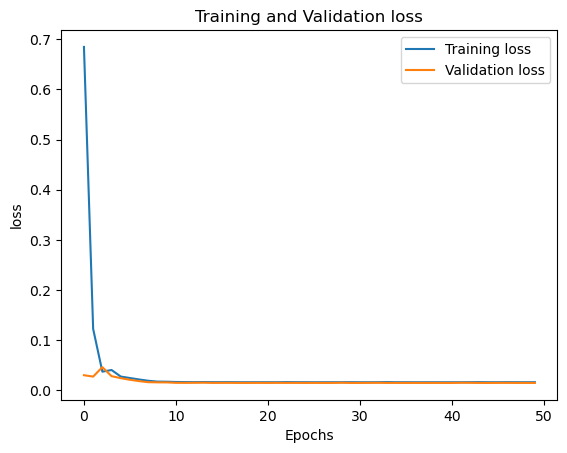

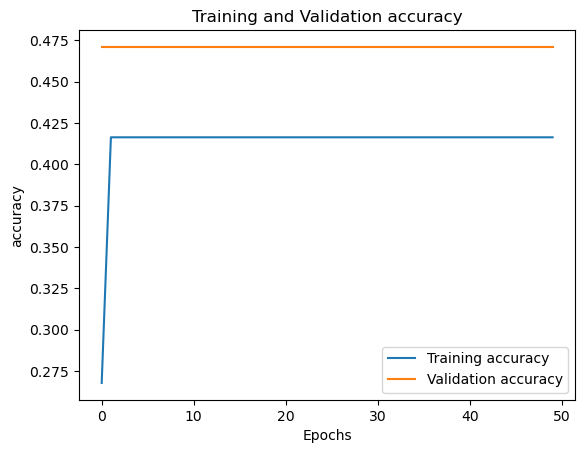

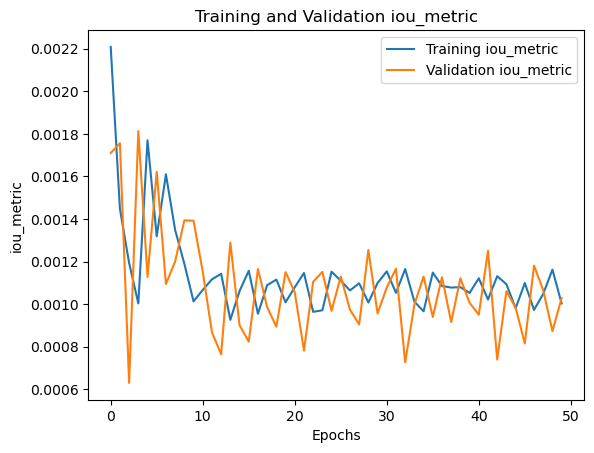

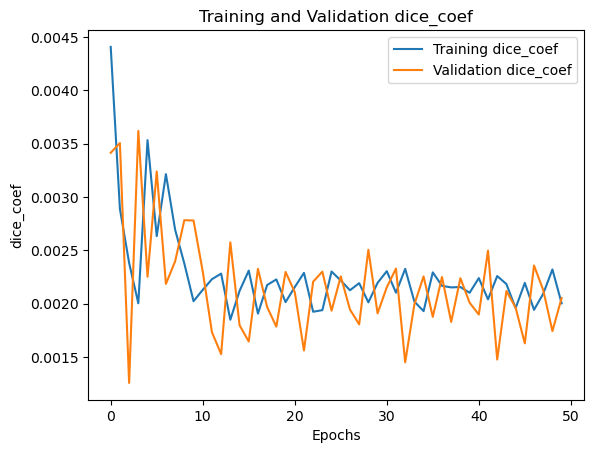

NameError: name 'X_val' is not defined

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from osgeo import gdal
import datetime
from tqdm.keras import TqdmCallback  # Importer TqdmCallback
import gc  # Importer le garbage collector

# Configure TensorFlow for GPU usage
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

K = tf.keras.backend

# Disable oneDNN custom operations
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Set TensorFlow logging level
tf.get_logger().setLevel('INFO')

# Ensure UTF-8 encoding for stdout and stderr
#sys.stdout.reconfigure(encoding='utf-8')
#sys.stderr.reconfigure(encoding='utf-8')

def iou_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    smooth = 1e-6
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    smooth = 1e-6
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

# Define U-Net model
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', iou_metric, dice_coef])

    return model

# Prepare the data
def preprocess_data(images, labels, img_size=(256, 256)):
    images_resized = [cv2.resize(img, img_size) for img in images]
    labels_resized = [cv2.resize(lbl, img_size) for lbl in labels]
    
    images_resized = np.array(images_resized) / 255.0
    labels_resized = np.array(labels_resized) / 255.0
    
    labels_resized = np.expand_dims(labels_resized, axis=-1) # Add channel dimension
    
    return images_resized, labels_resized

# Load images and labels
def load_data():
    test_path = glob.glob("../data/SWED/test/images/*")
    print(test_path[0])
    print(len(test_path))

    input_images = []
    rgb_images = []
    labels = []

    for path in tqdm(test_path, desc="Loading data"):
        try:
            img, rgb_img, label = load_test(path)
            input_images.append(img)
            rgb_images.append(rgb_img)
            labels.append(label)
        except Exception as e:
            print(f"Error with image {path}: {e}")

    return rgb_images, labels

# Assuming load_test is already defined
def load_test(path):
    img = gdal.Open(path).ReadAsArray()
    stack_img = np.stack(img, axis=-1)
    rgb_img = get_rgb(stack_img)
    
    label_path = path.replace("images", "labels").replace("image", "label")
    label = gdal.Open(label_path).ReadAsArray()
    
    return stack_img, rgb_img, label

def get_rgb(img):
    """Return normalized RGB channels from sentinel image"""
    rgb_img = img[:, :, [3,2,1]]
    rgb_normalize = np.clip(rgb_img/10000, 0, 0.3)/0.3
    return rgb_normalize

# Load and preprocess the data
rgb_images, labels = load_data()
X, y = preprocess_data(rgb_images, labels)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the model
input_shape = (256, 256, 3)  # Shape of input images
model = unet_model(input_shape)
model.summary()

# Define callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('unet_model.weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger('training_log.csv', append=True),
    tensorboard_callback,
    TqdmCallback(verbose=1)  # Ajouter TqdmCallback
]

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks, validation_data=(X_val, y_val), verbose=1)

# Free up memory
del X_train, y_train, X_val, y_val
gc.collect()
K.clear_session()
tf.compat.v1.reset_default_graph()

# Save the final model
model.save('unet_model_final.keras')

# Plot the training and validation metrics
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'iou_metric', 'dice_coef']
    for metric in metrics:
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'Training and Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        plt.show()

plot_metrics(history)

# Evaluate the model on the validation set
val_loss, val_accuracy, val_iou, val_dice = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation IoU: {val_iou}")
print(f"Validation Dice Coefficient: {val_dice}")

# Function to generate label from RGB image using trained model
def generate_label(image, model):
    img_resized = cv2.resize(image, (256, 256))
    img_resized = img_resized / 255.0
    img_resized = np.expand_dims(img_resized, axis=0)
    
    pred = model.predict(img_resized)
    pred = (pred > 0.5).astype(np.uint8)
    pred = np.squeeze(pred, axis=0)
    
    pred_resized = cv2.resize(pred, (image.shape[1], image.shape[0]))
    
    return pred_resized

# Example usage
example_image = rgb_images[0] # Replace with actual image
generated_label = generate_label(example_image, model)

# Display the result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(example_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Generated Label')
plt.imshow(generated_label, cmap='gray')
plt.axis('off')

plt.show()
